In [13]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import sys

sys.path.append("../includes")

import models
import utils

from PIL import Image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Load images

1f41e
1f98b


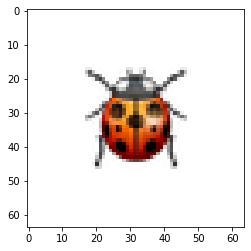

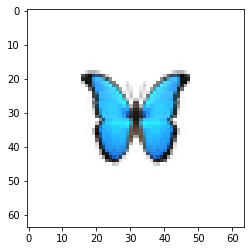

In [14]:
image_1 = utils.load_emoji("🐞", 32, 16).to(device)
image_2 = utils.load_emoji("🦋", 32, 16).to(device)

plt.imshow(image_1.transpose(0, 2).cpu())
plt.show()
plt.imshow(image_2.transpose(0, 2).cpu())
plt.show()

img_size = 64

# Initialize model

In [15]:
n_channels = 16
hidden_size = 64

images = torch.stack([image_1, image_2])

model = models.Automata((img_size, img_size), n_channels, hidden_size, device).to(device)

# Initialize pool

In [16]:
pool_size = 1024
batch_size = 16

# initialize pool with seeds
seed = torch.zeros(n_channels, img_size, img_size).to(device)
seed[3:, img_size//2, img_size//2] = 1

pool_initials = seed[None, :].repeat(pool_size, 1, 1, 1)
pool_targets = image_1[None, :].repeat(pool_size, 1, 1, 1)

pool_target_ids = torch.zeros(pool_size).long()
# 0 for image_1, 1 for image_2

# Train model

In [7]:
n_epochs = 10000
lr = 0.001

losses = []

criterion = nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):

    iterations = 100

    pool_indices = torch.Tensor(random.sample(range(pool_size), batch_size)).long()

    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states, iterations)

    phenotypes = out[:, :4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)

    per_sample_loss = loss.mean((1, 2, 3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()

    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()

    # get indices of min- and max-loss samples

    replacements = out.detach()
    replacements[max_loss_indices] = seed.clone()

    # high-loss outputs are re-tasked with
    # mapping the seed to the first image,

    # low-loss outputs are tasked with mapping
    # mapping to the other image
    pool_target_ids[pool_indices[max_loss_indices]] = 0

    pool_targets[pool_indices[max_loss_indices]] = images[0]

    pool_initials[pool_indices] = replacements

    if i % 100 == 0:

        print(i, np.log10(float(total_loss.cpu().detach())))


    losses.append(float(total_loss))

0 -1.3949244423963556
100 -1.6811285962503404
200 -1.5470195480110867
300 -1.6652039227467825
400 -1.6327119325083306
500 -1.6294357406727977
600 -1.6398301170926541
700 -1.6293210292633558
800 -1.6766857140718319
900 -1.9141908023726988
1000 -1.85183489344183
1100 -2.041009484693773
1200 -2.071192465822219
1300 -2.2173769913053434
1400 -2.2180844076037
1500 -2.3675918714006388
1600 -2.375247215992874
1700 -2.408744205955942
1800 -2.461771505589307
1900 -2.413572174232471
2000 -2.442116221594497
2100 -2.5071237901749015
2200 -2.5089860798890413
2300 -2.5419981583346822
2400 -2.5215973234747127
2500 -2.5102059878449916
2600 -2.586075450113228
2700 -2.5369295073349414
2800 -2.6009642239739366
2900 -2.461015291544993
3000 -2.531072454520628
3100 -2.5889307361475473
3200 -2.5422484877294407
3300 -2.6309842393970637
3400 -2.6297292041276887
3500 -2.556017882374938
3600 -2.540164396665337
3700 -2.6079743038253467
3800 -2.6922705395936783
3900 -2.580119037996274
4000 -2.5650917817347527
4100 

In [ ]:
plt.plot(np.log10(losses))

# Load model checkpoint

In [18]:
model.load_state_dict(
    torch.load("../models/metamorphosis_9900", map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [19]:
video = utils.get_model_history(model, seed, 1000)
utils.channels_to_gif("../videos/metamorphosis_channels.gif", video)
utils.colors_to_gif("../videos/metamorphosis_colors.gif", video)